In [1]:
import gzip
import json
import os
import pickle
from typing import Literal

import numpy as np
import pandas as pd
import seaborn as sns
from colorama import Fore, Style
from huggingface_hub import hf_hub_download
from matplotlib import pyplot as plt
from pymatgen.core import Lattice
from pymatgen.ext.matproj import MPRester
from tabulate import tabulate

from xtalmet.crystal import Crystal
from xtalmet.distance import d_amd, d_comp, d_magpie, d_smat, d_wyckoff

/rds/general/user/mn825/home/proj/xtalmet/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Table 1: Distances between example pairs of crystals based on composition and structure metrics.

In [2]:
MP_API_KEY = ""  # set your API key
# MP_API_KEY = os.getenv("MP_API_KEY")
mpr = MPRester(MP_API_KEY)
pairs = [
	["mp-2133"],  # same composition, same structure
	["mp-2133", "mp-2229"],  # same composition, different structure
	["mp-2133", "mp-804"],  # different composition, same structure
	["mp-2133", "mp-34202"],  # different composition, different structure
]
texts = [
	"wz-ZnO(mp-2133) vs wz-ZnO(mp-2133, 2x2x2 supercell) - same composition, same structure",
	"wz-ZnO(mp-2133) vs rs-ZnO(mp-2229) - same composition, different structure",
	"wz-ZnO(mp-2133) vs wz-GaN(mp-804) - different composition, same structure",
	"wz-ZnO(mp-2133) vs Bi2Te3(mp-34202) - different composition, different structure",
]
for pair, text in zip(pairs, texts, strict=False):
	print(text)
	docs = mpr.materials.summary.search(material_ids=pair)

	xtal_1 = Crystal.from_Structure(docs[0]["structure"])
	if len(docs) == 1:
		# get 2x2x2 supercell
		frac_coords_1 = xtal_1.frac_coords
		species_1 = xtal_1.species
		frac_coords_2 = []
		species_2 = []
		for frac_coord, specie in zip(frac_coords_1, species_1, strict=False):
			for i in range(2):
				for j in range(2):
					for k in range(2):
						frac_coords_2.append(
							[
								(frac_coord[0] + i) / 2,
								(frac_coord[1] + j) / 2,
								(frac_coord[2] + k) / 2,
							]
						)
						species_2.append(specie)
		xtal_2 = Crystal(
			lattice=Lattice.from_dict(
				{
					"a": xtal_1.lattice.a * 2,
					"b": xtal_1.lattice.b * 2,
					"c": xtal_1.lattice.c * 2,
					"alpha": xtal_1.lattice.alpha,
					"beta": xtal_1.lattice.beta,
					"gamma": xtal_1.lattice.gamma,
				}
			),
			species=species_2,
			coords=frac_coords_2,
		)
	else:
		xtal_2 = Crystal.from_Structure(docs[1]["structure"])

	print(f"d_smat: {d_smat(xtal_1, xtal_2)}")
	print(f"d_comp: {d_comp(xtal_1, xtal_2)}")
	print(f"d_wyckoff: {d_wyckoff(xtal_1, xtal_2)}")
	print(f"d_magpie: {d_magpie(xtal_1, xtal_2):.3e}")
	print(f"d_amd: {d_amd(xtal_1, xtal_2):.3e}")
	print()

wz-ZnO(mp-2133) vs wz-ZnO(mp-2133, 2x2x2 supercell) - same composition, same structure
d_smat: 0.0
d_comp: 0.0
d_wyckoff: 0.0
d_magpie: 0.000e+00
d_amd: 4.441e-15

wz-ZnO(mp-2133) vs rs-ZnO(mp-2229) - same composition, different structure
d_smat: 1.0
d_comp: 0.0
d_wyckoff: 1.0
d_magpie: 0.000e+00
d_amd: 1.042e+00

wz-ZnO(mp-2133) vs wz-GaN(mp-804) - different composition, same structure
d_smat: 1.0
d_comp: 1.0
d_wyckoff: 0.0
d_magpie: 6.298e+02
d_amd: 9.684e-02

wz-ZnO(mp-2133) vs Bi2Te3(mp-34202) - different composition, different structure
d_smat: 1.0
d_comp: 1.0
d_wyckoff: 1.0
d_magpie: 1.070e+03
d_amd: 3.240e+00



### Table 2: Uniqueness (U) and Novelty (N) results.

In [3]:
MODELS = [
	"cdvae",
	"diffcsp",
	"diffcsppp",
	"mattergen",
	"chemeleon",
    "adit",
]
MODEL_NAMES = {
	"cdvae": "CDVAE",
	"diffcsp": "DiffCSP",
	"diffcsppp": "DiffCSP++",
	"mattergen": "MatterGen",
	"chemeleon": "Chemeleon-DNG",
	"adit": "ADiT",
}
DISTANCES = ["smat", "comp", "wyckoff", "magpie", "amd"]
DISTANCE_NAMES = {
	"smat": r"$d_\mathrm{smat}$",
	"comp": r"$d_\mathrm{comp}$",
	"wyckoff": r"$d_\mathrm{wyckoff}$",
	"magpie": r"$d_\mathrm{magpie}$",
	"amd": r"$d_\mathrm{amd}$",
}
METRIC_NAMES = {
	"uniqueness": "Uniqueness",
	"novelty": "Novelty",
}
SCREEN_NAMES = {
	"none": "No screen",
	"ehull": "E_hull",
}
TIME_NAMES = {
	"uni_total": "Uni",
	"nov_total": "Nov",
}
RSLT_DIR = os.path.join(os.getcwd(), "results", "mp20")

In [4]:
def print_table_metric(
	metric: Literal["uniqueness", "novelty"], screen: Literal["none", "ehull"]
) -> None:
	"""Print a table showing the uniqueness/novelty results of the experiment.

	Args:
		metric (Literal): The metric to display in the table.
		screen (Literal): The screening method used.
	"""
	print(f"{METRIC_NAMES[metric]} ({SCREEN_NAMES[screen]})")
	headers = ["model"] + DISTANCES
	rows = []
	for model in MODELS:
		with open(os.path.join(RSLT_DIR, model, "results.json")) as f:
			data = json.load(f)
		rows.append([data[d][screen][metric] for d in DISTANCES])
	values_highlighted = np.max(np.array(rows), axis=0).tolist()
	rows_highlighted = [
		[
			Fore.RED + Style.BRIGHT + str(cell) + Style.RESET_ALL
			if cell == values_highlighted[i]
			else str(cell)
			for i, cell in enumerate(row)
		]
		for row in rows
	]
	print(
		tabulate(
			[[MODEL_NAMES[MODELS[i]]] + row for i, row in enumerate(rows_highlighted)],
			headers=headers,
			tablefmt="grid",
			floatfmt=".4f",
		)
	)

In [5]:
for metric in METRIC_NAMES:
    for screen in SCREEN_NAMES:
        print_table_metric(metric, screen)
        print("\n")

Uniqueness (No screen)
+---------------+--------+--------+-----------+-----------+--------+
| model         |   smat |   comp |   wyckoff |    magpie |    amd |
+===============+========+========+===========+===========+========+
| CDVAE         | 0.9945 | 0.9717 |    0.0045 | 1795.0511 | 1.2069 |
+---------------+--------+--------+-----------+-----------+--------+
| DiffCSP       | 0.9771 | 0.9461 |    0.0324 | 1981.5799 | 1.5912 |
+---------------+--------+--------+-----------+-----------+--------+
| DiffCSP++     | 0.9806 | 0.9522 |    0.1910 | 2070.4490 | 1.3768 |
+---------------+--------+--------+-----------+-----------+--------+
| MatterGen     | 0.9838 | 0.9523 |    0.0470 | 2088.9824 | 1.4145 |
+---------------+--------+--------+-----------+-----------+--------+
| Chemeleon-DNG | 0.9791 | 0.9373 |    0.0637 | 2083.8927 | 2.6791 |
+---------------+--------+--------+-----------+-----------+--------+
| ADiT          | 0.8841 | 0.7743 |    0.0038 | 2073.5381 | 1.2725 |
+----------

### Table 4: Ratio of samples that are classified as thermodynamically metastable, i.e., $E_\mathrm{hull} \le$ 0.1[eV/atom].

In [6]:
headers = [MODEL_NAMES[model] for model in MODELS]
rslts = []
for model in MODELS:
	with gzip.open(
		os.path.join(RSLT_DIR, model, "screen_ehull.pkl.gz"),
		"rb",
	) as f:
		valid_indices = pickle.load(f)
	rslts.append(np.sum(valid_indices) / len(valid_indices))
print(
	tabulate(
		[rslts],
		headers=headers,
		tablefmt="grid",
		floatfmt=".4f",
	)
)


+---------+-----------+-------------+-------------+-----------------+--------+
|   CDVAE |   DiffCSP |   DiffCSP++ |   MatterGen |   Chemeleon-DNG |   ADiT |
+=========+===========+=============+=============+=================+========+
|  0.0348 |    0.3087 |      0.2871 |      0.3646 |          0.3909 | 0.3708 |
+---------+-----------+-------------+-------------+-----------------+--------+


### Table 5: Computation time [s] required to calculate the uniqueness and novelty metrics on all the 10k samples generated from CDVAE trained on the MP20 dataset. A single CPU (AMD EPYC 7742) with 32 GB of RAM was used.

In [ ]:
def print_table_time(
	model: Literal[
		"cdvae",
		"diffcsp",
		"diffcsppp",
		"mattergen",
		"chemeleon",
		"adit",
	],
) -> None:
	"""Print a table showing the computation time for each model.

	Args:
		model (Literal): The model to display the time for.
	"""
	print(f"Computation time [s] for {MODEL_NAMES[model]}")
	with open(os.path.join(RSLT_DIR, model, "results.json")) as f:
		model_rslt = json.load(f)
	path = hf_hub_download(
		repo_id="masahiro-negishi/xtalmet",
		filename="mp20/train/times.json",
		repo_type="dataset",
		revision="v0.1.1",
	)
	with open(path, "rb") as f:
		dataset_rslt = json.load(f)

	headers = [] + DISTANCES
	rows = []
	rows.append([model_rslt[d]["none"]["uni_total"] for d in DISTANCES])
	rows.append(
		[
			model_rslt[d]["none"]["nov_total"]
			- model_rslt[d]["none"]["nov_emb_gen"]
			+ model_rslt[d]["none"]["uni_emb"]
			- model_rslt[d]["none"]["nov_emb_train"]
			+ dataset_rslt[f"d_{d}"]
			for d in DISTANCES
		]
	)
	print(
		tabulate(
			[
				[TIME_NAMES[key]] + row
				for key, row in zip(TIME_NAMES, rows, strict=False)
			],
			headers=headers,
			tablefmt="grid",
			floatfmt=".3e",
		)
	)

In [8]:
print_table_time("cdvae")

Computation time [s] for CDVAE
+-----+-----------+-----------+-----------+-----------+-----------+
|     |      smat |      comp |   wyckoff |    magpie |       amd |
+=====+===========+===========+===========+===========+===========+
| Uni | 1.682e+04 | 8.487e+00 | 2.918e+01 | 6.096e+02 | 4.343e+00 |
+-----+-----------+-----------+-----------+-----------+-----------+
| Nov | 4.438e+04 | 2.394e+01 | 3.968e+02 | 2.140e+03 | 3.970e+01 |
+-----+-----------+-----------+-----------+-----------+-----------+


### Figure 2: 2D plots showing the uniqueness and novelty of each model, which were computed after screening for thermodynamic stability. Different plots correspond to different distance functions. Pareto-optimal models are highlighted with a black circle.

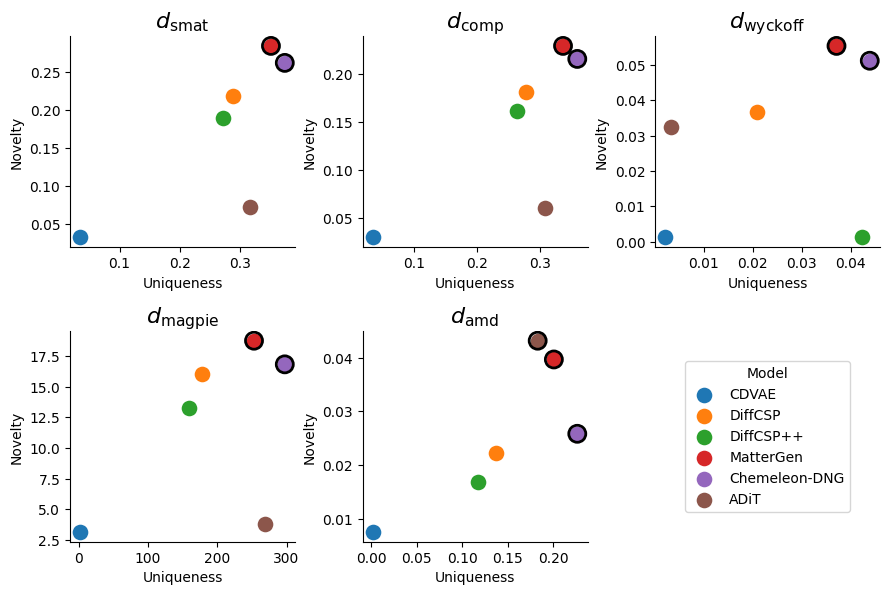

In [9]:
uniqueness_scores = []
novelty_scores = []
models = []
distances = []
for model in MODELS:
    with open(os.path.join(RSLT_DIR, model, "results.json")) as f:
        data = json.load(f)
    for distance in DISTANCES:
        uniqueness_scores.append(data[distance]["ehull"]["uniqueness"])
        novelty_scores.append(data[distance]["ehull"]["novelty"])
        models.append(MODEL_NAMES[model])
        distances.append(DISTANCE_NAMES[distance])
df = pd.DataFrame(
    {
        "Model": models,
        "Distance": distances,
        "Uniqueness": uniqueness_scores,
        "Novelty": novelty_scores,
    }
)

g = sns.FacetGrid(
    df, col="Distance", col_wrap=3, hue="Model", sharex=False, sharey=False
)
g.map(sns.scatterplot, "Uniqueness", "Novelty", s=150)
g.set_titles(col_template="{col_name}", size=16)
g.set_axis_labels("Uniqueness", "Novelty")

for ax in g.axes:
    ax.set_xlabel("Uniqueness")
    ax.set_ylabel("Novelty")

# highlight the Pareto front
for idx, distance in enumerate(DISTANCES):
    sub_df = df[(df["Distance"] == DISTANCE_NAMES[distance])]
    # Find Pareto front
    p_uni = []
    p_nov = []
    for _, row_1 in sub_df.iterrows():
        is_pareto = True
        for _, row_2 in sub_df.iterrows():
            if row_1["Model"] == row_2["Model"]:
                continue
            if (
                row_1["Uniqueness"] <= row_2["Uniqueness"]
                and row_1["Novelty"] <= row_2["Novelty"]
                and (
					row_1["Uniqueness"] < row_2["Uniqueness"]
					or row_1["Novelty"] < row_2["Novelty"]
				)
            ):
                is_pareto = False
                break
        if is_pareto:
            p_uni.append(row_1["Uniqueness"])
            p_nov.append(row_1["Novelty"])
    g.axes[idx].scatter(
        p_uni, p_nov, facecolors="none", edgecolors="black", linewidth=2, s=150
    )

# legend
handles = g._legend_data.values()
labels = g._legend_data.keys()
ax_legend = g.figure.add_subplot(2, 3, 6)
ax_legend.legend(
    handles,
    labels,
    loc="center",
    title="Model",
)
ax_legend.axis("off")

g.figure.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()
plt.close(g.figure)

### Table 6: $d_\mathrm{smat}$-based uniqueness score calculated on a set of 10k generated samples that were shuffled with different seeds. The final two rows show the average and standard deviation across five seeds.

In [10]:
headers = [] + [MODEL_NAMES[model] for model in MODELS]
rows = [[f"seed = {seed}"] + [None] * len(MODELS) for seed in range(5)]
for idx, model in enumerate(MODELS):
	path = os.path.join(RSLT_DIR, model, "mtx_uni_smat.pkl.gz")
	with gzip.open(path, "rb") as f:
		d_mtx = pickle.load(f)
	for seed in range(5):
		n_samples = len(d_mtx)
		indices = np.random.RandomState(seed).permutation(n_samples)
		d_mtx_shuffled = d_mtx[indices][:, indices]
		n_unique = sum(
			[1 if np.all(d_mtx_shuffled[i, :i] != 0) else 0 for i in range(n_samples)]
		)
		uniqueness = n_unique / n_samples
		rows[seed][idx + 1] = uniqueness
ave_row = ["ave"] + [
	sum([rows[seed][idx + 1] for seed in range(5)]) / 5 for idx in range(len(MODELS))
]
std_row = ["std"] + [
	np.std([rows[seed][idx + 1] for seed in range(5)]) for idx in range(len(MODELS))
]
ave_row = ["ave"] + [
	sum([rows[seed][idx + 1] for seed in range(5)]) / 5 for idx in range(len(MODELS))
]
std_row = ["std"] + [
	np.std([rows[seed][idx + 1] for seed in range(5)]) for idx in range(len(MODELS))
]
rows.append(ave_row)
rows.append(std_row)
print(
	tabulate(
		rows,
		headers=headers,
		tablefmt="grid",
		floatfmt=".5f",
	)
)


+----------+---------+-----------+-------------+-------------+-----------------+---------+
|          |   CDVAE |   DiffCSP |   DiffCSP++ |   MatterGen |   Chemeleon-DNG |    ADiT |
+==========+=========+===========+=============+=============+=================+=========+
| seed = 0 | 0.99420 |   0.97700 |     0.98090 |     0.98390 |         0.97920 | 0.88390 |
+----------+---------+-----------+-------------+-------------+-----------------+---------+
| seed = 1 | 0.99450 |   0.97710 |     0.98090 |     0.98380 |         0.97930 | 0.88400 |
+----------+---------+-----------+-------------+-------------+-----------------+---------+
| seed = 2 | 0.99400 |   0.97710 |     0.98060 |     0.98390 |         0.97890 | 0.88370 |
+----------+---------+-----------+-------------+-------------+-----------------+---------+
| seed = 3 | 0.99440 |   0.97710 |     0.98080 |     0.98380 |         0.97880 | 0.88390 |
+----------+---------+-----------+-------------+-------------+-----------------+---------+